In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv("Patient_withRUCA_withage.csv")
#excluding metastatic and unspecified cancer codes
df = df[df['Cancer Description'] != 'Unspecified cancer']
df = df[df['Cancer Description'] != 'Metastatic cancer']
df.shape

(7459, 17)

In [3]:
'''Create Initial Dataframe'''

#discretize age
agelabels = ['18 to 65','66 to 75','75 to 85','>85']
df['Agecat'] = pd.cut(df.Age,bins=[0, 65, 75, 85, 110],labels=agelabels)

#select columns
clusterdf = df[['Age', 'Agecat', 'Gender', 'Race/Ethnicity', 'Stage', 'Clinical Trial Participant', 'Tobacco Use', 
              'Cancer Description', 'RUCA']].copy()

#collapse race into only 2 categories, given imbalance
clusterdf = clusterdf.rename({'Race/Ethnicity' : 'Race'}, axis = 1)
clusterdf["Race"] = clusterdf["Race"].replace(to_replace=["White or Caucasian", "Unk"], value="White")
clusterdf = clusterdf.replace(to_replace=["African American", "American Indian or Alaskan Native", "Other",
                                         "Native Hawaiian or Other Pacific Islander", "Asian"], value="Nonwhite")

clusterdf.shape

(7459, 9)

In [4]:
#select diagnoses
#combine tumors
diagnoses = ['Esophageal cancer', 'Gastric cancer', 'Colorectal cancer', 'Pancreatic cancer', 
            'Head and neck cancer', 'Lung cancer', 'Breast cancer', 'Prostate cancer', 
            'Urothelial/bladder cancer']
clusterdf = clusterdf[clusterdf['Cancer Description'].isin(diagnoses)]
clusterdf = clusterdf.replace(to_replace=["Gastric cancer", "Esophageal cancer", "Colorectal cancer",
                                         "Pancreatic cancer"], value="GI cancer")
clusterdf = clusterdf.replace(to_replace=["Head and neck cancer", "Lung cancer"], value="Respiratory cancer")
clusterdf = clusterdf.replace(to_replace=["Prostate cancer", "Urothelial/bladder cancer"], 
                              value="GU cancer")

clusterdf["Race"].value_counts()

White       4938
Nonwhite     131
Name: Race, dtype: int64

In [5]:
cluster_RUCAdf = clusterdf.dropna(subset=['RUCA'])
cluster_RUCAdf.shape

(3224, 9)

The mean age for the dataset is  67.84276977707634
The mean age for the rows with RUCA codes assigned is  67.76861042183623
The t-statistic is  0.28386825589792314 and the p-value is  0.776519968949566


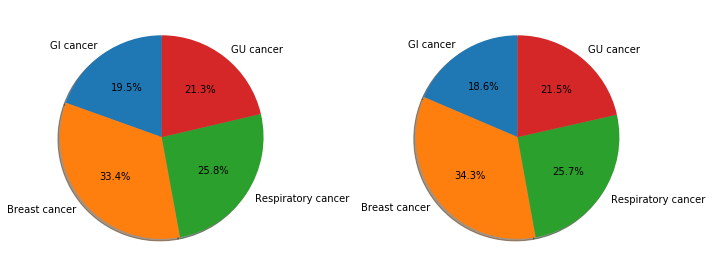

In [6]:
'''Looking at Data Distribution for the Dataframes:
Does using only columns with non-null RUCA codes
change the distribution?'''

#Looking at mean age
print("The mean age for the dataset is ", clusterdf["Age"].mean())
print("The mean age for the rows with RUCA codes assigned is ", 
      cluster_RUCAdf["Age"].mean())
#Two-sample t-test
t, p = stats.ttest_ind(clusterdf["Age"], cluster_RUCAdf["Age"], equal_var=False)
print("The t-statistic is ", t, "and the p-value is ", p)

#Looking at distribution of cancer diagnoses
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
sizes = []
labels = ['GI cancer', 'Breast cancer', 'Respiratory cancer', 
            'GU cancer']
for diagnosis in labels:
    sizes.append(clusterdf[clusterdf["Cancer Description"]==diagnosis].shape[0])
    
explode = (0,0,0,0,0,0)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)


sizes = []

for diagnosis in labels:
    sizes.append(cluster_RUCAdf[cluster_RUCAdf["Cancer Description"]==diagnosis].shape[0])
    
explode = (0,0,0,0,0,0)
ax2.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)

fig.tight_layout()
plt.show()

#The distributions look pretty close


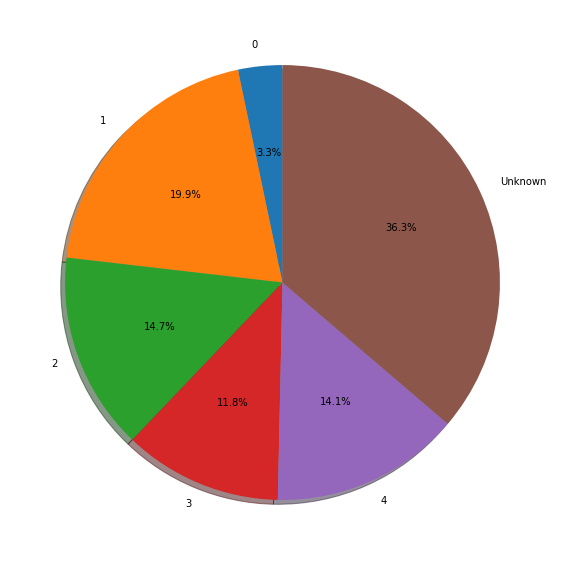

In [7]:
'''Examine stage distribution'''

sizes = []
stagelabels = ["0","1","2","3","4","Unknown"]
for stage in stagelabels:
    sizes.append(cluster_RUCAdf[cluster_RUCAdf["Stage"]==stage].shape[0])
    
explode = (0,0,0,0,0,0)
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=stagelabels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.show()

#About 1/3 are 'unknown'

In [8]:
'''Transforming data in preparation for clustering:
1. String to categorical datatypes
2. Label encode
3. One-hot encode
'''

features = ['Age', 'Gender', 'Race', 'Clinical Trial Participant',
          'Tobacco Use', 'Cancer Description', 'RUCA']
finaldf = cluster_RUCAdf[features]
finaldf[features[1:6]] = finaldf[features[1:6]].astype("category")

#OneHot encoding
finaldf = pd.get_dummies(finaldf, columns=features[1:6])

#min/max normalization for RUCA code, age
finaldf["RUCA"] = finaldf["RUCA"].apply(lambda x: x/10)
finaldf["Age"] = finaldf["Age"].apply(lambda x: (x-21)/78)

#export for use in WEKA
finaldf.to_csv('FinalDF_cluster.csv')
finaldf.head()

/Users/eeramsdale/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Age,RUCA,Gender_Female,Gender_Male,Race_Nonwhite,Race_White,Clinical Trial Participant_No,Clinical Trial Participant_Yes,Tobacco Use_Current Smoker,Tobacco Use_Former Smoker,Tobacco Use_Non Smoker,Tobacco Use_Unknown,Cancer Description_Breast cancer,Cancer Description_GI cancer,Cancer Description_GU cancer,Cancer Description_Respiratory cancer
2,0.820513,0.2,0,1,0,1,1,0,0,0,1,0,0,0,1,0
4,0.858974,0.2,0,1,0,1,1,0,0,0,1,0,0,0,1,0
5,0.820513,0.3,1,0,0,1,1,0,0,1,0,0,0,0,0,1
7,0.769231,0.1,1,0,0,1,1,0,0,1,0,0,1,0,0,0
10,0.871795,0.2,0,1,0,1,1,0,0,1,0,0,0,0,0,1


For cluster number = 3
Silhouette Coefficient: 0.579
Calinski-Harabasz Score: 1501.889
Davies-Bouldin Score: 0.869
For cluster number = 4
Silhouette Coefficient: 0.584
Calinski-Harabasz Score: 1536.092
Davies-Bouldin Score: 0.954
For cluster number = 5
Silhouette Coefficient: 0.584
Calinski-Harabasz Score: 1533.917
Davies-Bouldin Score: 0.942
For cluster number = 6
Silhouette Coefficient: 0.573
Calinski-Harabasz Score: 1467.951
Davies-Bouldin Score: 0.851
For cluster number = 7
Silhouette Coefficient: 0.584
Calinski-Harabasz Score: 1536.092
Davies-Bouldin Score: 0.954
For cluster number = 8
Silhouette Coefficient: 0.579
Calinski-Harabasz Score: 1502.422
Davies-Bouldin Score: 0.888
For cluster number = 9
Silhouette Coefficient: 0.581
Calinski-Harabasz Score: 1505.693
Davies-Bouldin Score: 0.918
For cluster number = 10
Silhouette Coefficient: 0.584
Calinski-Harabasz Score: 1533.901
Davies-Bouldin Score: 0.941
For cluster number = 11
Silhouette Coefficient: 0.584
Calinski-Harabasz Score: 

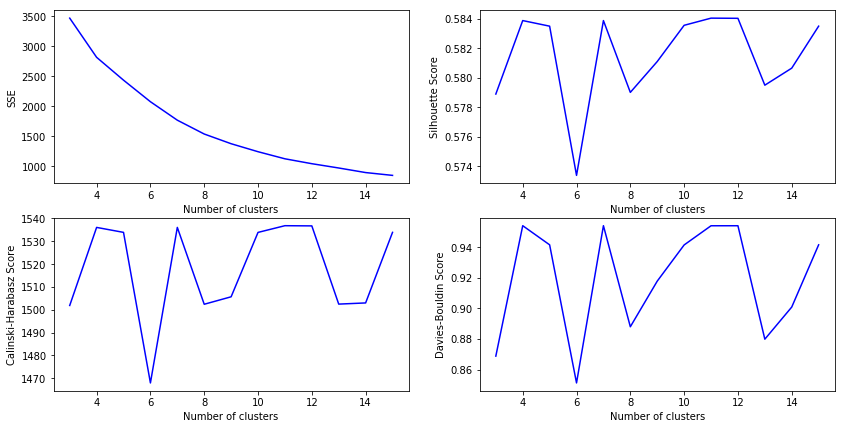

In [9]:
'''
K-means
'''

from sklearn.cluster import KMeans
from sklearn import metrics

cluster_range = range(3,16,1)
elbow = []
ss_km = []
ch_km = []
db_km = []
for n in cluster_range:
    km = KMeans(n_clusters = n).fit(finaldf)
    km_labels = KMeans(n_clusters = 10).fit_predict(finaldf)
    silhouette = metrics.silhouette_score(finaldf, km_labels)
    ch_score = metrics.calinski_harabasz_score(finaldf, km_labels)
    db_score = metrics.davies_bouldin_score(finaldf, km_labels)
    ss_km.append(silhouette)
    ch_km.append(ch_score)
    db_km.append(db_score)
    elbow.append(km.inertia_)
    print("For cluster number =", n)
    print("Silhouette Coefficient: %0.3f"
     % metrics.silhouette_score(finaldf, km_labels))
    print("Calinski-Harabasz Score: %0.3f"
     % metrics.calinski_harabasz_score(finaldf, km_labels))
    print("Davies-Bouldin Score: %0.3f"
     % metrics.davies_bouldin_score(finaldf, km_labels))
    #Finding the average SSE"
     
fig = plt.figure(figsize=(14,7))
fig.add_subplot(221)
plt.plot(cluster_range, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
fig.add_subplot(222)
plt.plot(cluster_range, ss_km,'b-',label='Silhouette Score')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
fig.add_subplot(223)
plt.plot(cluster_range, ch_km,'b-',label='Calinski-Harabasz Score')
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz Score")
fig.add_subplot(224)
plt.plot(cluster_range, db_km,'b-',label='Davies-Bouldin Score')
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin Score")
plt.show()


For minPts number = 10
Number of clusters: 26
Number of noise points: 115
Silhouette Coefficient: 0.690
Calinski-Harabasz Score: 1044.835
Davies-Bouldin Score: 1.189
For minPts number = 20
Number of clusters: 17
Number of noise points: 238
Silhouette Coefficient: 0.650
Calinski-Harabasz Score: 999.478
Davies-Bouldin Score: 1.262
For minPts number = 30
Number of clusters: 12
Number of noise points: 357
Silhouette Coefficient: 0.613
Calinski-Harabasz Score: 1061.965
Davies-Bouldin Score: 1.191
For minPts number = 40
Number of clusters: 12
Number of noise points: 361
Silhouette Coefficient: 0.612
Calinski-Harabasz Score: 1050.438
Davies-Bouldin Score: 1.196
For minPts number = 50
Number of clusters: 12
Number of noise points: 378
Silhouette Coefficient: 0.605
Calinski-Harabasz Score: 1009.811
Davies-Bouldin Score: 1.213
For minPts number = 60
Number of clusters: 10
Number of noise points: 487
Silhouette Coefficient: 0.573
Calinski-Harabasz Score: 973.508
Davies-Bouldin Score: 1.273
For mi

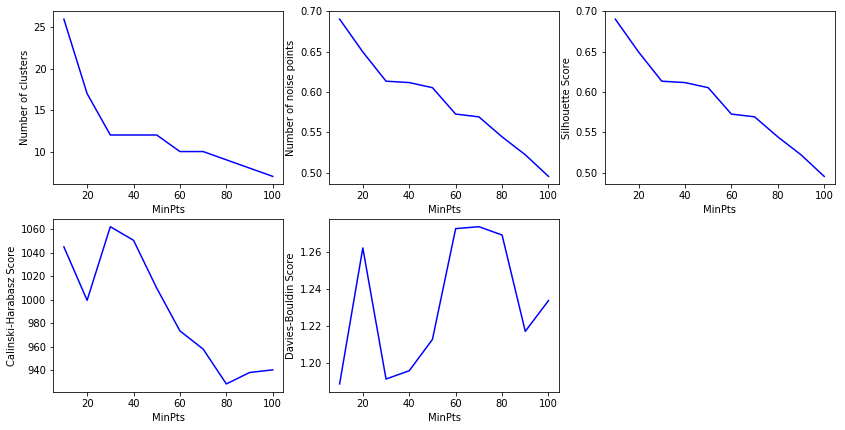

In [10]:
'''
DBSCAN clustering
'''
from sklearn.cluster import DBSCAN

minsample_range = range(10,110,10)
eps = 0.5
ss_db = []
ch_db = []
db_db = []
clus = []
noise = []
for n in minsample_range:
    db = DBSCAN(eps=eps, min_samples=n).fit(finaldf)
    db_labels = DBSCAN(eps=eps, min_samples=n).fit_predict(finaldf)
    db_noise_ = list(db_labels).count(-1)
    db_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    silhouette = metrics.silhouette_score(finaldf, db_labels)
    ch_score = metrics.calinski_harabasz_score(finaldf, db_labels)
    db_score = metrics.davies_bouldin_score(finaldf, db_labels)
    ss_db.append(silhouette)
    ch_db.append(ch_score)
    db_db.append(db_score)
    elbow.append(km.inertia_)
    clus.append(db_clusters_)
    noise.append(db_noise_)

    print("For minPts number =", n)
    print("Number of clusters:", db_clusters_)
    print("Number of noise points:", db_noise_)
    print("Silhouette Coefficient: %0.3f"
     % metrics.silhouette_score(finaldf, db_labels))
    print("Calinski-Harabasz Score: %0.3f"
     % metrics.calinski_harabasz_score(finaldf, db_labels))
    print("Davies-Bouldin Score: %0.3f"
     % metrics.davies_bouldin_score(finaldf, db_labels))
     
fig = plt.figure(figsize=(14,7))
fig.add_subplot(231)
plt.plot(minsample_range, clus,'b-')
plt.xlabel("MinPts")
plt.ylabel("Number of clusters")
fig.add_subplot(232)
plt.plot(minsample_range, ss_db,'b-')
plt.xlabel("MinPts")
plt.ylabel("Number of noise points")
fig.add_subplot(233)
plt.plot(minsample_range, ss_db,'b-')
plt.xlabel("MinPts")
plt.ylabel("Silhouette Score")
fig.add_subplot(234)
plt.plot(minsample_range, ch_db,'b-')
plt.xlabel("MinPts")
plt.ylabel("Calinski-Harabasz Score")
fig.add_subplot(235)
plt.plot(minsample_range, db_db,'b-')
plt.xlabel("MinPts")
plt.ylabel("Davies-Bouldin Score")
plt.show()



In [11]:
'''
OPTICS clustering
'''

from sklearn.cluster import OPTICS
from sklearn import metrics
optics = OPTICS(min_samples=175).fit_predict(finaldf)
opt_clusters_ = len(set(optics)) - (1 if -1 in optics else 0)
opt_noise_ = list(optics).count(-1)

print('Estimated number of clusters: %d' % opt_clusters_)
print('Estimated number of noise points: %d' % opt_noise_)
print("Silhouette Coefficient: %0.3f"
     % metrics.silhouette_score(finaldf, optics))
print("Calinski-Harabasz Score: %0.3f"
     % metrics.calinski_harabasz_score(finaldf, optics))
print("Davies-Bouldin Score: %0.3f"
     % metrics.davies_bouldin_score(finaldf, optics))


Estimated number of clusters: 7
Estimated number of noise points: 779
Silhouette Coefficient: 0.496
Calinski-Harabasz Score: 940.467
Davies-Bouldin Score: 1.234


For cluster number = 3
Silhouette Coefficient: 0.305
Calinski-Harabasz Score: 1175.856
Davies-Bouldin Score: 1.414
For cluster number = 4
Silhouette Coefficient: 0.364
Calinski-Harabasz Score: 1318.690
Davies-Bouldin Score: 1.322
For cluster number = 5
Silhouette Coefficient: 0.383
Calinski-Harabasz Score: 1234.049
Davies-Bouldin Score: 1.103
For cluster number = 6
Silhouette Coefficient: 0.422
Calinski-Harabasz Score: 1235.622
Davies-Bouldin Score: 1.091
For cluster number = 7
Silhouette Coefficient: 0.482
Calinski-Harabasz Score: 1354.037
Davies-Bouldin Score: 0.996
For cluster number = 8
Silhouette Coefficient: 0.521
Calinski-Harabasz Score: 1404.730
Davies-Bouldin Score: 1.012
For cluster number = 9
Silhouette Coefficient: 0.557
Calinski-Harabasz Score: 1498.780
Davies-Bouldin Score: 0.942
For cluster number = 10
Silhouette Coefficient: 0.562
Calinski-Harabasz Score: 1425.860
Davies-Bouldin Score: 0.955
For cluster number = 11
Silhouette Coefficient: 0.584
Calinski-Harabasz Score: 

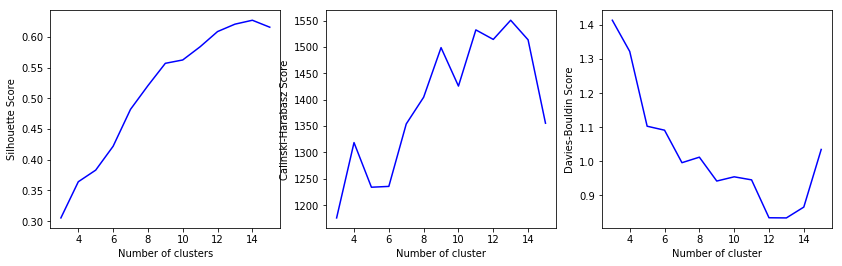

In [12]:
'''
Spectral clustering
'''
from sklearn.cluster import SpectralClustering


cluster_range = range(3,16,1)
ss_spec = []
ch_spec = []
db_spec = []
for n in cluster_range:
    spec = SpectralClustering(n_clusters=n,
         assign_labels="discretize",
         random_state=0).fit_predict(finaldf)
    silhouette = metrics.silhouette_score(finaldf, spec)
    ch_score = metrics.calinski_harabasz_score(finaldf, spec)
    db_score = metrics.davies_bouldin_score(finaldf, spec)
    ss_spec.append(silhouette)
    ch_spec.append(ch_score)
    db_spec.append(db_score)
    
    print("For cluster number =", n)
    print("Silhouette Coefficient: %0.3f"
     % metrics.silhouette_score(finaldf, spec))
    print("Calinski-Harabasz Score: %0.3f"
     % metrics.calinski_harabasz_score(finaldf, spec))
    print("Davies-Bouldin Score: %0.3f"
     % metrics.davies_bouldin_score(finaldf, spec))

     
fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plt.plot(cluster_range, ss_spec,'b-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
fig.add_subplot(132)
plt.plot(cluster_range, ch_spec,'b-')
plt.xlabel("Number of cluster")
plt.ylabel("Calinski-Harabasz Score")
fig.add_subplot(133)
plt.plot(cluster_range, db_spec,'b-')
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin Score")
plt.show()


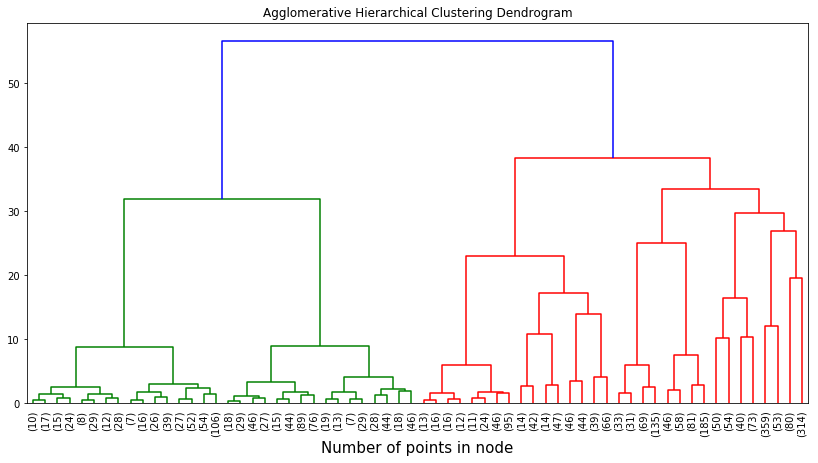

In [13]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(finaldf)
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='x', which='major', labelsize=15)
plt.title('Agglomerative Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=5, ax=ax)
plt.xlabel("Number of points in node", fontsize=15)
ax.tick_params(axis='x', which='major', labelsize=10)
plt.show()

For cluster number = 3
Silhouette Coefficient: 0.278
Calinski-Harabasz Score: 906.798
Davies-Bouldin Score: 1.579
For cluster number = 4
Silhouette Coefficient: 0.309
Calinski-Harabasz Score: 865.864
Davies-Bouldin Score: 1.685
For cluster number = 5
Silhouette Coefficient: 0.356
Calinski-Harabasz Score: 887.996
Davies-Bouldin Score: 1.476
For cluster number = 6
Silhouette Coefficient: 0.385
Calinski-Harabasz Score: 936.143
Davies-Bouldin Score: 1.329
For cluster number = 7
Silhouette Coefficient: 0.418
Calinski-Harabasz Score: 987.148
Davies-Bouldin Score: 1.251
For cluster number = 8
Silhouette Coefficient: 0.472
Calinski-Harabasz Score: 1051.561
Davies-Bouldin Score: 1.149
For cluster number = 9
Silhouette Coefficient: 0.512
Calinski-Harabasz Score: 1123.659
Davies-Bouldin Score: 1.141
For cluster number = 10
Silhouette Coefficient: 0.531
Calinski-Harabasz Score: 1169.308
Davies-Bouldin Score: 1.118
For cluster number = 11
Silhouette Coefficient: 0.555
Calinski-Harabasz Score: 1198.

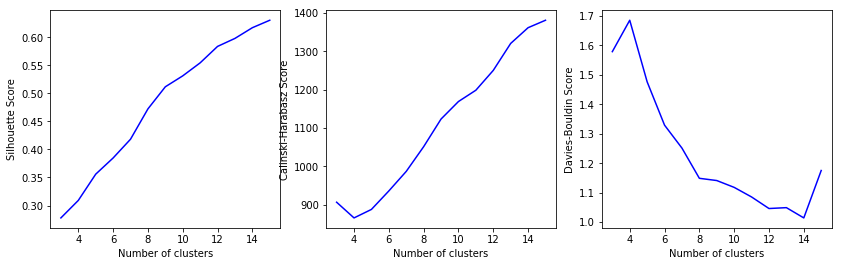

In [14]:
from sklearn.cluster import AgglomerativeClustering

cluster_range = range(3,16,1)
ss_agg = []
ch_agg = []
db_agg = []
for n in cluster_range:
    hier = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')  
    agg = hier.fit_predict(finaldf)
    np.count_nonzero(agg)
    silhouette = metrics.silhouette_score(finaldf, agg)
    ch_score = metrics.calinski_harabasz_score(finaldf, agg)
    db_score = metrics.davies_bouldin_score(finaldf, agg)
    ss_agg.append(silhouette)
    ch_agg.append(ch_score)
    db_agg.append(db_score)
    print("For cluster number =", n)
    print("Silhouette Coefficient: %0.3f"
     % metrics.silhouette_score(finaldf, agg))
    print("Calinski-Harabasz Score: %0.3f"
     % metrics.calinski_harabasz_score(finaldf, agg))
    print("Davies-Bouldin Score: %0.3f"
     % metrics.davies_bouldin_score(finaldf, agg))
     
fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plt.plot(cluster_range, ss_agg,'b-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
fig.add_subplot(132)
plt.plot(cluster_range, ch_agg,'b-')
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz Score")
fig.add_subplot(133)
plt.plot(cluster_range, db_agg,'b-')
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin Score")
plt.show()


In [15]:
'''
Adding columns to the dataset 
for cluster labels
'''
cluster_RUCAdf['Agglomerative'] = pd.Series(agg, index=finaldf.index)
cluster_RUCAdf['Spectral'] = pd.Series(spec, index=finaldf.index)
cluster_RUCAdf['OPTICS'] = pd.Series(optics, index=finaldf.index)
cluster_RUCAdf['DBSCAN'] = pd.Series(db_labels, index=finaldf.index)
cluster_RUCAdf['K_means'] = pd.Series(km_labels, index=finaldf.index)

cluster_RUCAdf.to_csv('Clusters.csv')
cluster_RUCAdf.head()

/Users/eeramsdale/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/eeramsdale/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eeramsdale/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,Age,Agecat,Gender,Race,Stage,Clinical Trial Participant,Tobacco Use,Cancer Description,RUCA,Agglomerative,Spectral,OPTICS,DBSCAN,K_means
2,85,75 to 85,Male,White,2,No,Non Smoker,GU cancer,2.0,8,7,0,0,3
4,88,>85,Male,White,2,No,Non Smoker,GU cancer,2.0,8,7,0,0,3
5,85,75 to 85,Female,White,Unknown,No,Former Smoker,Respiratory cancer,3.0,7,10,4,1,0
7,81,75 to 85,Female,White,Unknown,No,Former Smoker,Breast cancer,1.0,9,9,5,2,4
10,89,>85,Male,White,Unknown,No,Former Smoker,Respiratory cancer,2.0,5,6,2,3,1


array([0.36427759, 0.22689196, 0.11013803, 0.09974069, 0.06300023,
       0.04835325, 0.04589895, 0.02406016, 0.01038756, 0.00684778])

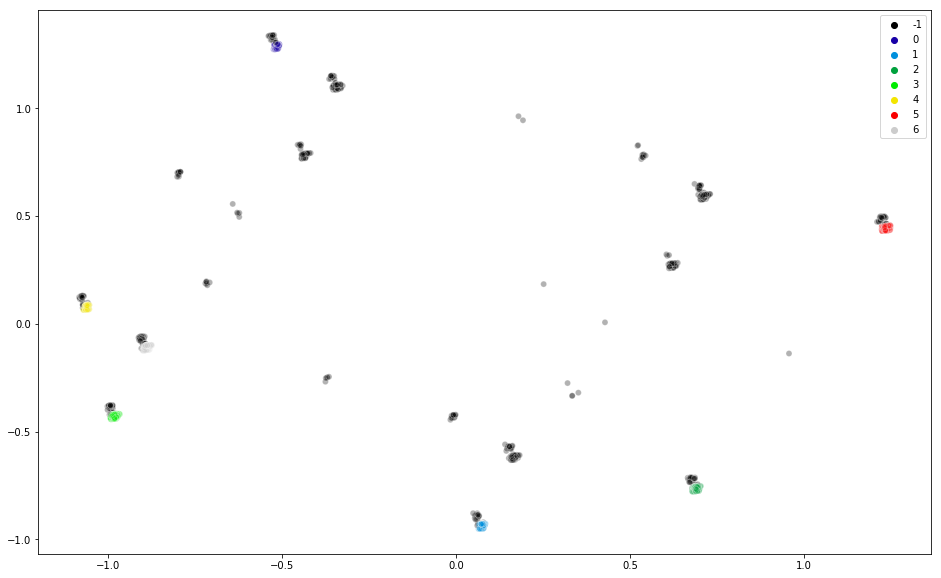

In [16]:
'''
PCA decomposition and plot
'''

from sklearn import decomposition
import seaborn as sns

#to examine variance ratios for first 10 components
pca = decomposition.PCA(n_components=10)
pca.fit(finaldf)

#2-D decomposition
pca_vis = decomposition.PCA(n_components=2)
pca_vis.fit(finaldf)
X = pca_vis.transform(finaldf)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X[:,0], y=X[:,1],
    hue=db_labels,
    palette="nipy_spectral",
    data=finaldf,
    legend="full",
    alpha=0.3
)

pca.explained_variance_ratio_

[-10.927362  -11.009356   -7.584063  ...  -2.5987246 -13.688728
   6.1896257]


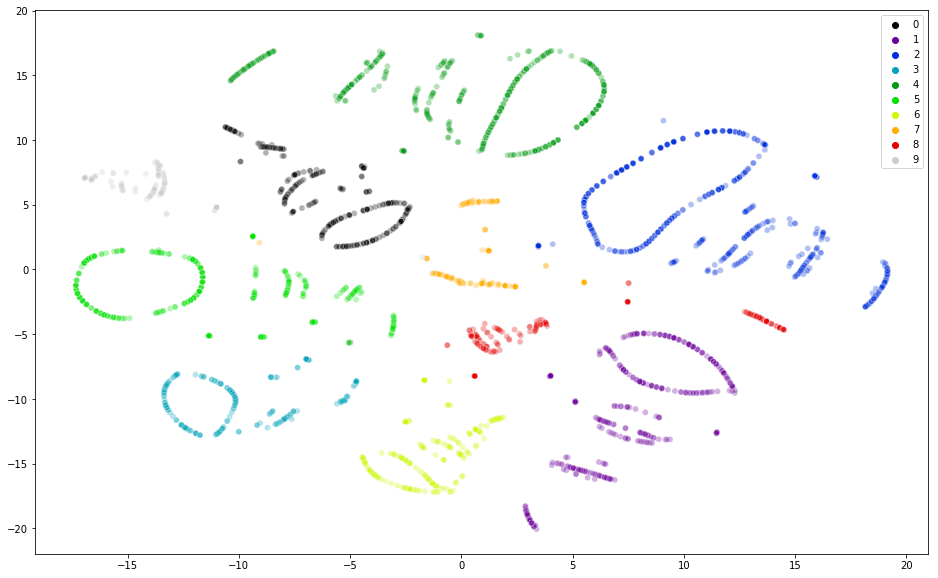

In [17]:
'''
t-SNE plots
'''
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(finaldf)

dim1 = tsne_results[:,0]
dim2 = tsne_results[:,1]
print(dim1)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=dim1, y=dim2,
    hue=km_labels,
    palette="nipy_spectral",
    data=finaldf,
    legend="full",
    alpha=0.3
)